# γ Gamma Fixed Model

This code comes as a fix for the previous code which was overfitting due to a leak of training data into the validation and test sets giving ridiculous validation accuracies of 99.95% in early stages of training.

The issue is visible from the validation/train accuracy graph shown below.
<img width=400 src="validation_accuracy.png"/>

The previous fix to this was to pull out only unique images from the full dataset so that there are no repeats of validation and test samples in the training set. This proved to be a flawed method as for some classes I was left with 0 instances of a given class.

Exploring the website where I got the dataset from further I found that they provide seprerate Test/Train datasets however most Test datasets don't have labels attached (i know right). I did find a version of the dataset that was used for a competition that did have the labels attached. I decided to load this in instead.

I skipped the augmentation step for simplicity

## 1. Loading in data

In [94]:
import os
import wget
import zipfile
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.math import confusion_matrix
from keras.callbacks import EarlyStopping
import pickle
import seaborn as sns

# Custom packages for this project
from road_labels import label_name
from colours import colour

In [63]:
### LOAD IN THE DATASET (276MB) ###

# Image Constants & Dimensions
IMG_WIDTH = 30
IMG_HEIGHT = 30
CHANNELS = 3
CLASSES = 43

MODELS_DIR = "models"

# Location of data
CUR_DIR = os.getcwd()
URL_TRAIN = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip"
URL_TEST = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Online-Test-Images-Sorted.zip"

In [34]:
# Function to load in train data
def load_roadsigns(path):
    # Initialise the output arrays
    X = [] # images
    y = np.array([]) # labels
    
    print("Resizing images...")
    # Iterate through all the directories, pull out images and resize
    for i in range(CLASSES):
        
        # Messing around with paths of where the data is found
        class_label = f"{i:05}"
        class_folder = path+f"/{class_label}"
        datasheet = pd.read_csv(class_folder+f"/GT-{class_label}.csv",delimiter=";")

        image_files = list(datasheet["Filename"])
        labels = list(datasheet["ClassId"])
        
        y = np.append(y,labels)
        
        # Open each image, resize and save into numpy array
        for image_file in tqdm(image_files):
            try: 
                image = Image.open(class_folder+"/"+image_file) 
                image = image.resize((IMG_WIDTH,IMG_HEIGHT)) 
                image = np.array(image)
                X.append(image)
            except: 
                print("Erorr loading in image")
                break
                
    # Converting to numpy arrays
    # It was actually quicker to do the appending in native lists and converting lol ¯\_(ツ)_/¯
    X = np.array(X)
    y = y.astype(int)
                
    return X, y


In [35]:
# Check if file already downloaded
if not os.path.isfile("GTSRB-Training_fixed.zip"):
    if not os.path.isdir("GTSRB_Train"):
        print("Downloading Train Dataset...")
        wget.download(URL_TRAIN,".")
        print("Downloaded!")
        
        # Unzip the file into a folder
        with zipfile.ZipFile("GTSRB-Training_fixed.zip","r") as zip_ref:
            zip_ref.extractall("./GTSRB_Train")
        
        os.remove("GTSRB-Training_fixed.zip")
    else:
        print("Train Dataset already downloaded.")
else:
    print("Train Dataset already downloaded.")
    
# Check if file already downloaded
if not os.path.isfile("GTSRB_Online-Test-Images-Sorted.zip"):
    if not os.path.isdir("GTSRB_Test"):
        print("Downloading Test Dataset...")
        wget.download(URL_TEST,".")
        print("Downloaded!")
        
        # Unzip the file into a folder
        with zipfile.ZipFile("GTSRB_Online-Test-Images-Sorted.zip","r") as zip_ref:
            zip_ref.extractall("./GTSRB_Test")
        
        os.remove("GTSRB_Online-Test-Images-Sorted.zip")
    else:
        print("Test Dataset already downloaded.")
else:
    print("Test Dataset already downloaded.")
    

# Load in and normalise the datasets    
X_train, y_train = load_roadsigns("GTSRB_Train/GTSRB/Training")
X_train = X_train/255

X_test, y_test = load_roadsigns("GTSRB_Test/GTSRB/Online-Test-sort")
X_test = X_test/255

Train Dataset already downloaded.
Test Dataset already downloaded.
Resizing images...


100%|███████████████████████████████████████| 180/180 [00:00<00:00, 1309.81it/s]


Resizing images...


100%|█████████████████████████████████████████| 60/60 [00:00<00:00, 1349.41it/s]


Now that the data is loaded in finally, we can explore it a little bit further.

In [47]:
# Functions to help with exploration

maps = ["Reds","Greens","Blues"]

# Here we can visualise our images and their corresponding labels
def plot_sign(X,y,n):
    plt.imshow(X[n])
    plt.title(label_name[y[n]])

def plot_sign_rgb(X,y,n):
    fig, ax = plt.subplots(1,CHANNELS,figsize=(10,10))
    for i in range(CHANNELS):
        ax[i].imshow(X[n][:, :, i],cmap=maps[i])
        ax[i].title.set_text(str(maps[i]))
        
# Function to get sign by label number
def get_sign_by_label(X,y,label):
    return X[y.tolist().index(label)]

def format_label(label):
    return label_name[label]+f" ({label})"

## 2. Quick Data Exploration 
Lets see one of each class for both the test and train datasets

In [45]:
print(f"Dimensions of training images array: {X_train.shape}")
print(f"Dimensions of training labels array: {y_train.shape}")

print(f"Dimensions of test images array: {X_test.shape}")
print(f"Dimensions of test labels array: {y_test.shape}")

Dimensions of training images array: (26640, 30, 30, 3)
Dimensions of training labels array: (26640,)
Dimensions of test images array: (12569, 30, 30, 3)
Dimensions of test labels array: (12569,)


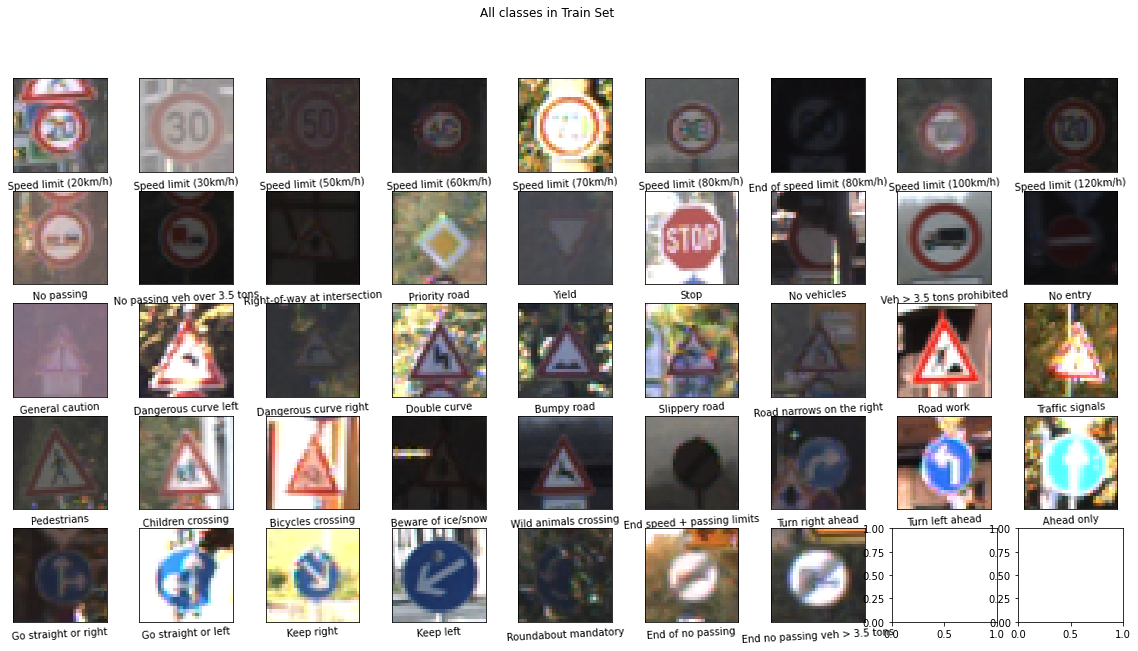

In [42]:
figdim = (5,9)

fig, ax = plt.subplots(figdim[0],figdim[1],figsize=(20,10))
fig.suptitle("All classes in Train Set")

label_count = 0

for i in range(figdim[0]):
    for j in range(figdim[1]):
        if label_count == 43:
            break
        ax[i][j].imshow(get_sign_by_label(X_train,y_train,label_count))
        ax[i][j].set_xlabel(label_name[label_count],rotation=3)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        label_count +=1

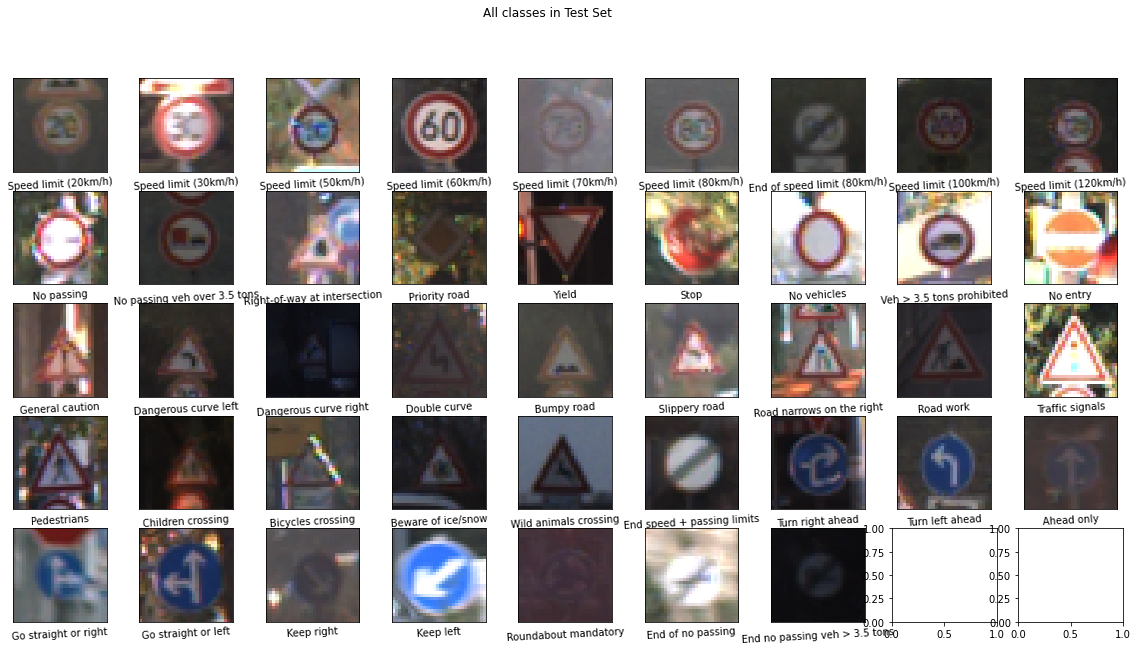

In [44]:
figdim = (5,9)

fig, ax = plt.subplots(figdim[0],figdim[1],figsize=(20,10))
fig.suptitle("All classes in Test Set")

label_count = 0

for i in range(figdim[0]):
    for j in range(figdim[1]):
        if label_count == 43:
            break
        ax[i][j].imshow(get_sign_by_label(X_test,y_test,label_count))
        ax[i][j].set_xlabel(label_name[label_count],rotation=3)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        label_count +=1

I did this just as a sanity check to make sure there is no data being replicated between train and test dataset.

We will now check the distribution of images in each class.

In [49]:
# Get the class distribution of the train augmented dataset
train_dist = pd.DataFrame({"label":np.unique(y_train),"count":np.bincount(y_train)})
train_dist["label_name"] = train_dist["label"].apply(format_label)
train_dist = train_dist.sort_values("count",ascending=False)

# Get the class distribution of the train augmented dataset
test_dist = pd.DataFrame({"label":np.unique(y_test),"count":np.bincount(y_test)})
test_dist["label_name"] = test_dist["label"].apply(format_label)
test_dist = test_dist.sort_values("count",ascending=False)

,label,count,label_name
2,2,750,Speed limit (50km/h) (2)
13,13,720,Yield (13)
1,1,720,Speed limit (30km/h) (1)
38,38,690,Keep right (38)
12,12,690,Priority road (12)


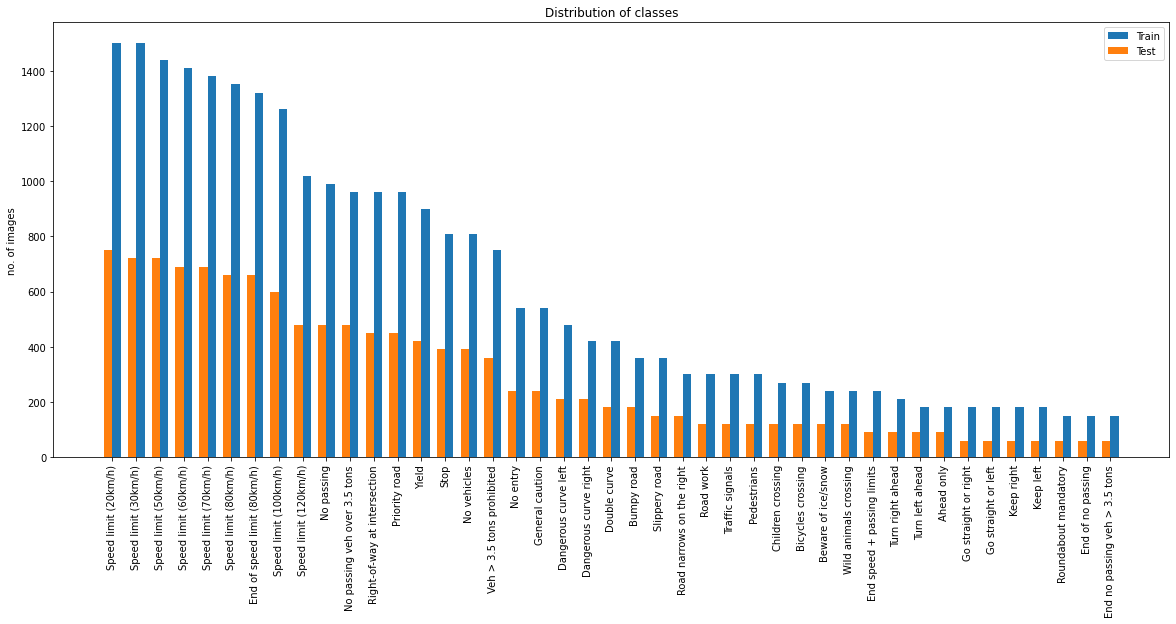

In [50]:
x = np.arange(len(train_dist["label"])) # the label locations
labels = list(label_name.values())
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,8))

train_aug = ax.bar(x + width/2, train_dist["count"], width, label='Train')
train = ax.bar(x - width/2, test_dist["count"], width, label='Test')

ax.set_xticks(x,labels,rotation=90)
ax.set_ylabel('no. of images')
ax.set_title('Distribution of classes')

ax.legend()

In [54]:
test_dist.head().sort_values("count",ascending=True)

,label,count,label_name
38,38,690,Keep right (38)
12,12,690,Priority road (12)
13,13,720,Yield (13)
1,1,720,Speed limit (30km/h) (1)
2,2,750,Speed limit (50km/h) (2)


Here we see much more samples for both test and train and a comparable distribution pattern between them. 

## 3. Splitting the data (Validation)
One problem now is that we need to make sure not to split the train dataset to make the validation set (the proper way to do it) and instead take the test set as it has unique images for fair validation.

In [57]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.1, random_state=42, shuffle=True)

In [58]:
# See shape of the train and test datasets
print(f"Train dataset shape: {X_train.shape}")
print(f"Validation dataset shape: {X_val.shape}")
print(f"Test dataset shape: {X_test.shape}")

Train dataset shape: (26640, 30, 30, 3)
Validation dataset shape: (1257, 30, 30, 3)
Test dataset shape: (11312, 30, 30, 3)


This is solid for test train and validation.

## 4. Constructing the model

In [62]:
model_gamma = keras.models.Sequential([
    # Convolution Layer
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    # Convolution Layer
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    # Neural Network
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

learning_rate = 0.001
epochs = 15

optimizer = Adam(learning_rate=learning_rate, decay=learning_rate / (epochs * 0.5))
model_gamma.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_gamma.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 128)         7

2022-04-12 23:55:58.845769: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [70]:
epochs = 30
gamma_history_file = "gamma_history.npy"
gamma_model_file = "model_gamma.pickle"

# Join with model directory file
gamma_history_file = os.path.join(MODELS_DIR,gamma_history_file)
gamma_model_file = os.path.join(MODELS_DIR,gamma_model_file)

es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

if not os.path.isfile(gamma_history_file) or not os.path.isfile(gamma_model_file):
    gamma_history = model_gamma.fit(X_train, y_train, batch_size=32, epochs=epochs,validation_data=(X_val, y_val),callbacks=[es])
    gamma_history = gamma_history.history
    np.save(gamma_history_file,gamma_history)
    with open(gamma_model_file, 'wb') as f:
        pickle.dump(model_gamma, f)
else:
    gamma_history = np.load(gamma_history_file,allow_pickle='TRUE').item()
    with open(gamma_model_file, 'rb') as f:
        model_gamma = pickle.load(f)

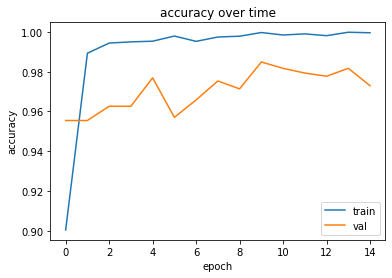

In [71]:
#alpha_history.history
# Loss
plt.plot(gamma_history['accuracy'])
plt.plot(gamma_history['val_accuracy'])
plt.title("accuracy over time")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

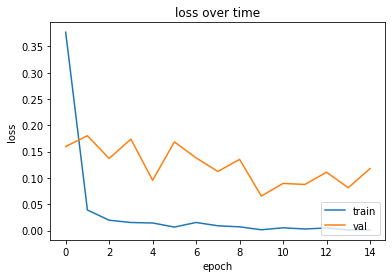

In [72]:
#gamma_history.history
plt.plot(gamma_history['loss'])
plt.plot(gamma_history['val_loss'])
plt.title("loss over time")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

This looks a little bit more normal as the validation accuracy is lower than the training accuracy. This means there is no data leaking from training to validation.

In [73]:
model_gamma.evaluate(X_test,y_test)

354/354 [==============================] - 5s 13ms/step - loss: 0.0854 - accuracy: 0.9806


[0.0853617861866951, 0.9806400537490845]

This is also a little bit more normal looking than 99% on test dataset :)

In [75]:
probabilities_gamma = model_gamma.predict(X_test)
predictions_gamma = np.argmax(probabilities_gamma,axis=1)

In [76]:
# List of indexes that model got wrong
wrong_indices = [i for i,v in enumerate(predictions_gamma) if predictions_gamma[i]!=y_test[i]]
wrong_indices[:10]

[14, 23, 112, 194, 334, 345, 374, 383, 461, 538]

Model Predicted: End of no passing
Confidence: 1.0


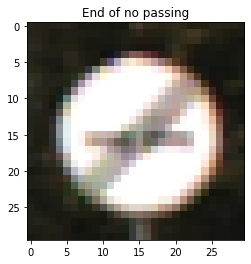

In [91]:
# Pick a number
n = 10

# Plot and check if prediction matches
plot_sign(X_test,y_test,n)
print(colour.BOLD+f"Model Predicted: {label_name[predictions_gamma[n]]}"+colour.END)
print(colour.BOLD+f"Confidence: {probabilities_gamma[n][predictions_gamma[n]]}"+colour.END)

Text(0.5, 114.0, 'Precited Labels')

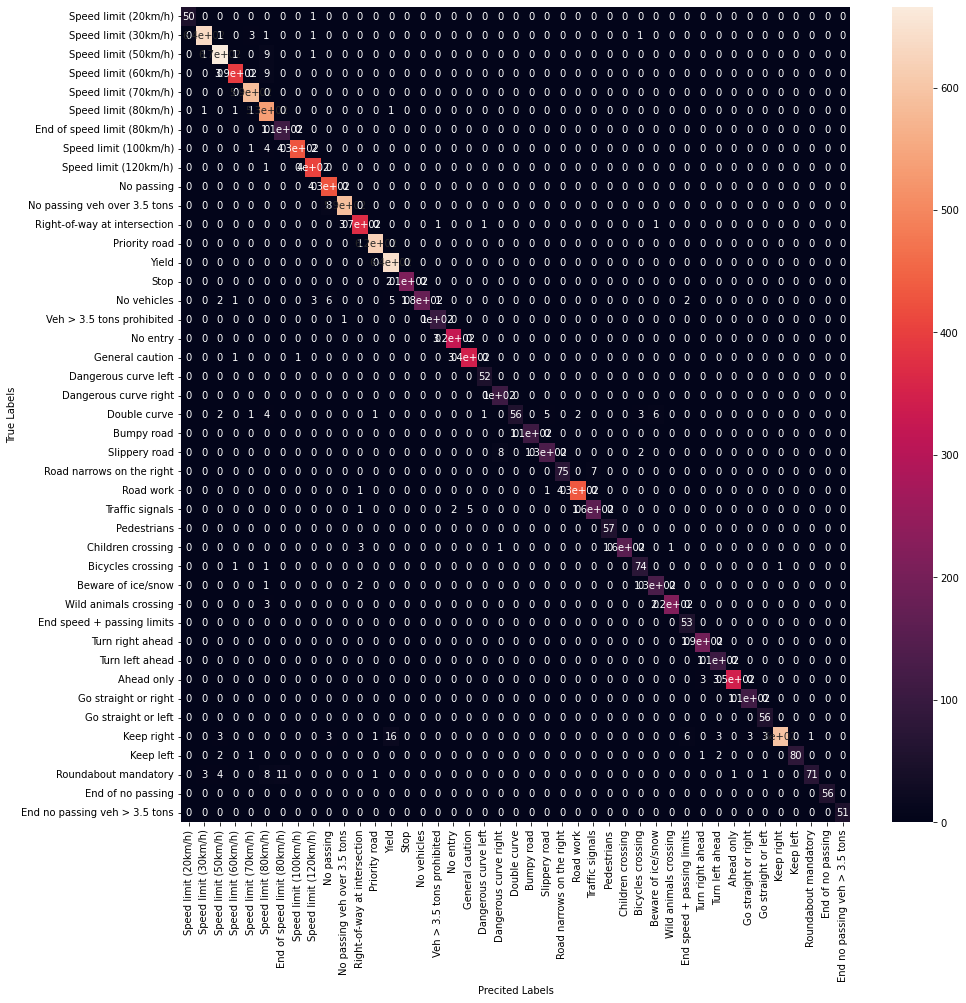

In [95]:
cm_mat_gamma = np.array(confusion_matrix(y_test,predictions_gamma))
cm_df_gamma = pd.DataFrame(cm_mat_gamma, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (15,15))
ax = sns.heatmap(cm_df_gamma, annot=True)
ax.set_ylabel("True Labels")
ax.set_xlabel("Predicted Labels")

array([[38, 13, 16],
       [40, 6, 11],
       [2, 5, 9],
       [3, 5, 9],
       [10, 9, 8]], dtype=object)

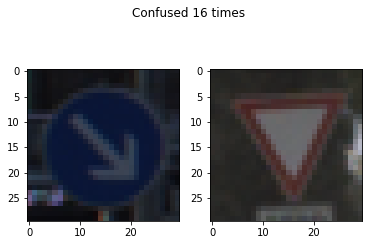

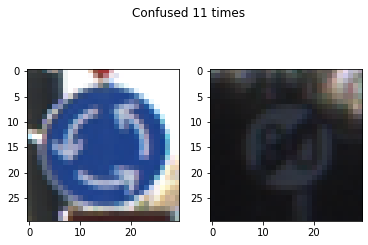

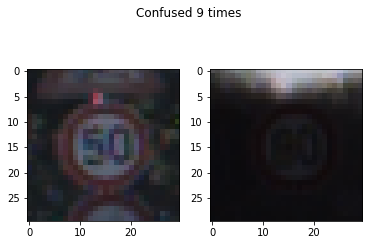

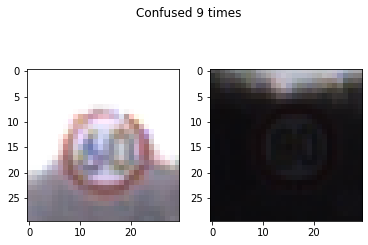

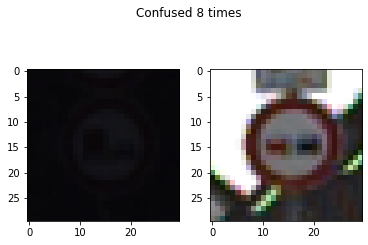

In [98]:
def most_confused_signs(conf_mat,number):
    # Create empty 0x3 array
    # true , predicted , number confused
    most_confused = np.empty((0,3),dtype=tuple)
    
    # Iterate through matrix to find most confused values
    for i in range(len(conf_mat)):
        for j in range(len(conf_mat[i])):
            if i != j and conf_mat[i][j] != 0:
                most_confused = np.vstack((most_confused,tuple((int(i),int(j),int(conf_mat[i][j]))))) 
    
    # Sort the numpy array and reverse it to get the most confused types.
    most_confused = most_confused[most_confused[:,2].argsort()][::-1]
    
    # Plot the images side by side
    for i in range(number):  
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(get_sign_by_label(X_test,y_test,most_confused[i,0]))
        ax[0].set
        ax[1].imshow(get_sign_by_label(X_test,y_test,most_confused[i,1]))
        fig.suptitle(f"Confused {most_confused[i,2]} times")

    return most_confused[:number]

most_confused_signs(cm_mat_gamma,5)

It works well and I think it will generalise better but lets see it working on an image outside of the given dataset.

Model Predicted: No entry


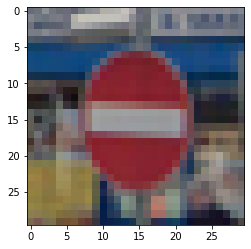

In [100]:
no_entry = Image.open('no_entry.png') 
no_entry = no_entry.resize((IMG_WIDTH,IMG_HEIGHT)) 
no_entry = np.array(no_entry)[:,:,:3]

plt.imshow(no_entry)

entry_predictions = model_gamma.predict(np.array([no_entry]))
entry_predictions = np.argmax(entry_predictions,axis=1)

print("Model Predicted: " +label_name[int(entry_predictions)])